# Sentiment Analysis with Multilingual BERT Embeddings
Este notebook construye un pipeline reproducible que usa `paraphrase-multilingual-MiniLM-L12-v2` para generar embeddings y entrenar un `MLPClassifier` optimizado sobre el dataset `poem_sentiment`.

## 1. Configurar dependencias y entorno
Instala las dependencias clave, importa librerías de análisis y fija la semilla para reproducibilidad.

In [1]:
# Instala las dependencias esenciales (ejecuta esta celda una vez)
%pip install numpy pandas scikit-learn sentence-transformers matplotlib seaborn joblib tqdm ipywidgets fastparquet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Ejecuta esta celda después de instalar las dependencias en la celda anterior
import os
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

import joblib
import warnings

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Cargar particiones de `poem_sentiment`
Descarga las particiones desde Hugging Face usando las rutas parquet especificadas y confirma sus dimensiones.

In [3]:
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
base_uri = "hf://datasets/google-research-datasets/poem_sentiment/"
parquet_engine = "fastparquet"
df_train = pd.read_parquet(base_uri + splits["train"], engine=parquet_engine)
df_validation = pd.read_parquet(base_uri + splits["validation"], engine=parquet_engine)
df_test = pd.read_parquet(base_uri + splits["test"], engine=parquet_engine)

for name, df in {"train": df_train, "validation": df_validation, "test": df_test}.items():
    print(f"{name.title()} shape: {df.shape}")
    print(df.head(2), "\n")

Train shape: (892, 3)
   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2 

Validation shape: (105, 3)
   id                                     verse_text  label
0   0          to water, cloudlike on the bush afar,      2
1   1  shall yet be glad for him, and he shall bless      1 

Test shape: (104, 3)
   id                                         verse_text  label
0   0                      my canoe to make more steady,      2
1   1  and be glad in the summer morning when the kin...      1 



## 3. Preprocesar texto y etiquetas
Aplica una limpieza ligera, asegura la consistencia de las etiquetas y genera mapeos descriptivos para interpretabilidad.

In [4]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return " ".join(text.strip().split())

train_texts = df_train["verse_text"].astype(str).apply(clean_text)
validation_texts = df_validation["verse_text"].astype(str).apply(clean_text)
test_texts = df_test["verse_text"].astype(str).apply(clean_text)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["label"])
y_validation = label_encoder.transform(df_validation["label"])
y_test = label_encoder.transform(df_test["label"])

original_to_encoded = {int(orig): int(label_encoder.transform([orig])[0]) for orig in label_encoder.classes_}
label_name_map = {
    0: "negative",
    1: "positive",
    2: "no_impact",
    3: "mixed",
}
encoded_to_name = {encoded: label_name_map.get(orig, f"class_{orig}")
                    for orig, encoded in original_to_encoded.items()}

print("Encoded label mapping:")
for orig, encoded in original_to_encoded.items():
    label_name = label_name_map.get(orig, f"class_{orig}")
    print(f"  Original {orig} → Encoded {encoded} ({label_name})")

Encoded label mapping:
  Original 0 → Encoded 0 (negative)
  Original 1 → Encoded 1 (positive)
  Original 2 → Encoded 2 (no_impact)
  Original 3 → Encoded 3 (mixed)


### Exploración de distribución de etiquetas
Verifica que las etiquetas originales corresponden con los nombres esperados y revisa el desbalance por partición.


=== TRAIN ===


,label_original,label_name,count,encoded_label,share_pct
0,0,negative,155,0,17.376682
1,1,positive,133,1,14.910314
2,2,no_impact,555,2,62.219731
3,3,mixed,49,3,5.493274


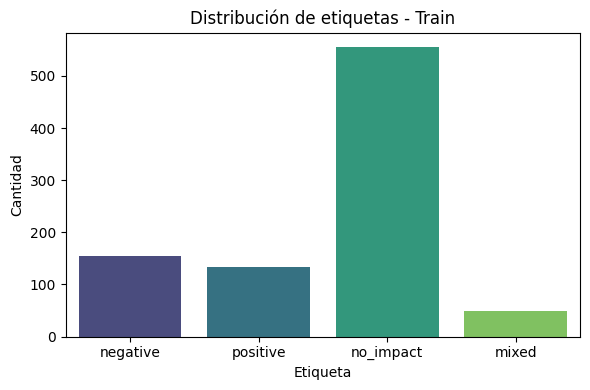


=== VALIDATION ===


,label_original,label_name,count,encoded_label,share_pct
0,0,negative,19,0,18.095238
1,1,positive,17,1,16.190476
2,2,no_impact,69,2,65.714286


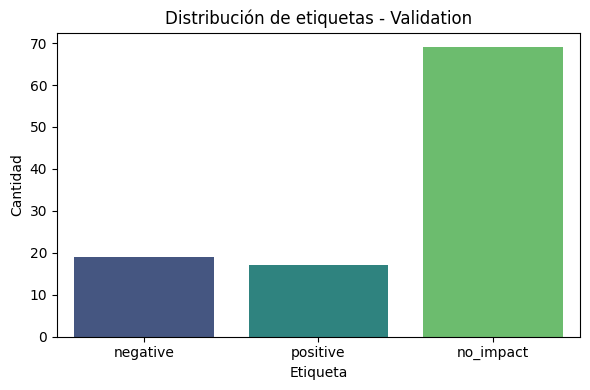


=== TEST ===


,label_original,label_name,count,encoded_label,share_pct
0,0,negative,19,0,18.269231
1,1,positive,16,1,15.384615
2,2,no_impact,69,2,66.346154


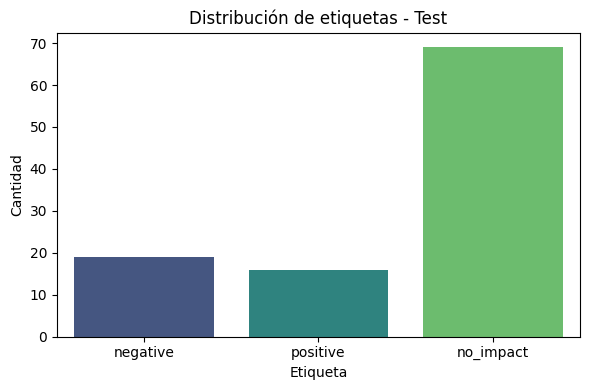

In [5]:
def summarize_labels(df, split_name):
    counts = df["label"].value_counts().sort_index()
    summary = pd.DataFrame({
        "label_original": counts.index.astype(int),
        "label_name": [label_name_map.get(int(lbl), f"class_{lbl}") for lbl in counts.index],
        "count": counts.values,
    })
    summary["encoded_label"] = label_encoder.transform(summary["label_original"].to_numpy())
    summary["share_pct"] = (summary["count"] / summary["count"].sum()) * 100
    display(summary)
    
    plt.figure(figsize=(6, 4))
    sns.barplot(data=summary, x="label_name", y="count", palette="viridis")
    plt.title(f"Distribución de etiquetas - {split_name}")
    plt.xlabel("Etiqueta")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.show()

for split_name, df_split in [("Train", df_train), ("Validation", df_validation), ("Test", df_test)]:
    print(f"\n=== {split_name.upper()} ===")
    summarize_labels(df_split, split_name)

## 4. Generar embeddings con `multilingual_bert`
Inicializa el modelo `paraphrase-multilingual-MiniLM-L12-v2` y codifica los textos en lotes para mantener el uso de memoria bajo control.

In [ ]:
def encode_texts(texts, model, batch_size=32):
    embeddings = []
    for start in range(0, len(texts), batch_size):
        batch_texts = texts.iloc[start:start + batch_size].tolist()
        batch_embeddings = model.encode(
            batch_texts,
            batch_size=batch_size,
            convert_to_numpy=True,
            show_progress_bar=False,
            device=DEVICE,
        )
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

multilingual_model_name = "paraphrase-multilingual-MiniLM-L12-v2"
multilingual_model = SentenceTransformer(multilingual_model_name, device=DEVICE)
print(f"Loaded embedder: {multilingual_model_name}")

X_train_embeddings = encode_texts(train_texts, multilingual_model, batch_size=32)
X_validation_embeddings = encode_texts(validation_texts, multilingual_model, batch_size=32)
X_test_embeddings = encode_texts(test_texts, multilingual_model, batch_size=32)

print(f"Train embeddings shape: {X_train_embeddings.shape}")
print(f"Validation embeddings shape: {X_validation_embeddings.shape}")
print(f"Test embeddings shape: {X_test_embeddings.shape}")
print("")

Loaded embedder: paraphrase-multilingual-MiniLM-L12-v2
Train embeddings shape: (892, 384)
Validation embeddings shape: (105, 384)
Test embeddings shape: (104, 384)



## 5. Escalar *features* y aplicar PCA opcional
Estandariza los embeddings con `StandardScaler` y reduce dimensionalidad con PCA solo si logra conservar al menos 95% de la varianza.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_embeddings)
X_validation_scaled = scaler.transform(X_validation_embeddings)
X_test_scaled = scaler.transform(X_test_embeddings)

pca = None
pca_variance = 1.0
if X_train_scaled.shape[1] > 50:
    pca = PCA(n_components=0.95, random_state=SEED)
    X_train_ready = pca.fit_transform(X_train_scaled)
    X_validation_ready = pca.transform(X_validation_scaled)
    X_test_ready = pca.transform(X_test_scaled)
    pca_variance = float(pca.explained_variance_ratio_.sum())
    print(f"PCA applied: reduced to {X_train_ready.shape[1]} dims (var={pca_variance:.4f})")
else:
    X_train_ready = X_train_scaled
    X_validation_ready = X_validation_scaled
    X_test_ready = X_test_scaled
    print("PCA skipped: dimensionality already compact")

PCA applied: reduced to 149 dims (var=0.9509)


## 6. Entrenar `MLPClassifier` optimizado
Ajusta una red `MLPClassifier` profunda con *early stopping* y registra la curva de pérdida para monitorizar convergencia.

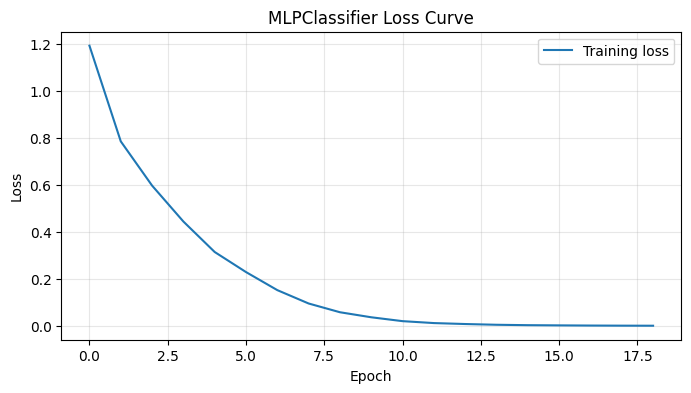

Training epochs run: 19


In [10]:
mlp_clf = MLPClassifier(
    early_stopping=True,
    hidden_layer_sizes=(512, 256, 128, 64),
    learning_rate="adaptive",
    max_iter=300,
    random_state=SEED,
    validation_fraction=0.15,
)
mlp_clf.fit(X_train_ready, y_train)

loss_curve = mlp_clf.loss_curve_
plt.figure(figsize=(8, 4))
plt.plot(loss_curve, label="Training loss")
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Training epochs run: {mlp_clf.n_iter_}")
if hasattr(mlp_clf, "best_iteration_") and mlp_clf.best_iteration_ is not None:
    print(f"Best iteration (early stopping): {mlp_clf.best_iteration_}")

## 7. Evaluar en validación y prueba
Obtén métricas clave —accuracy, F1 ponderado, reporte de clasificación y matrices de confusión— para validar el rendimiento del pipeline.

=== VALIDATION METRICS ===
Accuracy: 0.8381
F1-weighted: 0.8308
              precision    recall  f1-score   support

    negative       0.77      0.89      0.83        19
    positive       0.67      0.47      0.55        17
   no_impact       0.89      0.91      0.90        69
       mixed       0.00      0.00      0.00         0

    accuracy                           0.84       105
   macro avg       0.58      0.57      0.57       105
weighted avg       0.83      0.84      0.83       105



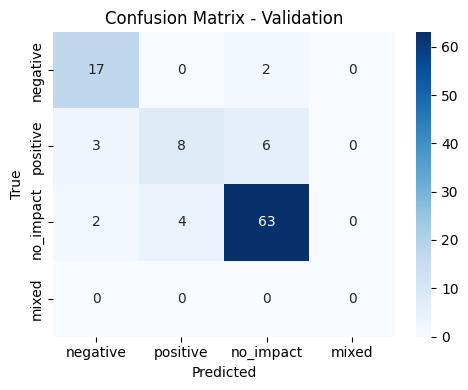

=== TEST METRICS ===
Accuracy: 0.7692
F1-weighted: 0.7715
              precision    recall  f1-score   support

    negative       0.62      0.79      0.70        19
    positive       0.67      0.50      0.57        16
   no_impact       0.85      0.83      0.84        69
       mixed       0.00      0.00      0.00         0

    accuracy                           0.77       104
   macro avg       0.54      0.53      0.53       104
weighted avg       0.78      0.77      0.77       104



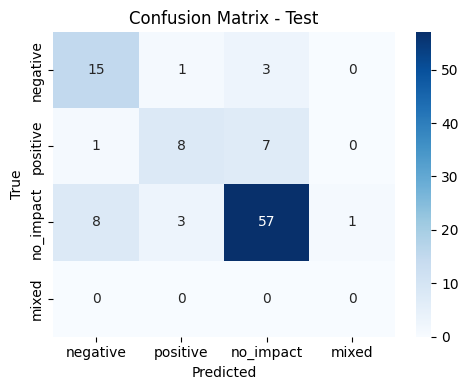

In [11]:
def evaluate_split(X, y_true, split_name):
    labels_order = sorted(encoded_to_name.keys())
    y_pred = mlp_clf.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average="weighted")
    report = classification_report(
        y_true,
        y_pred,
        labels=labels_order,
        target_names=[encoded_to_name[idx] for idx in labels_order],
        zero_division=0,
    )
    print(f"=== {split_name.upper()} METRICS ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-weighted: {f1_w:.4f}")
    print(report)
    
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[encoded_to_name[idx] for idx in labels_order],
                yticklabels=[encoded_to_name[idx] for idx in labels_order])
    plt.title(f"Confusion Matrix - {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return {"accuracy": accuracy, "f1_weighted": f1_w}

validation_metrics = evaluate_split(X_validation_ready, y_validation, "Validation")
test_metrics = evaluate_split(X_test_ready, y_test, "Test")

## 8. Guardar artefactos del modelo
Persiste los componentes críticos del pipeline (`scaler`, `pca`, MLP y metadatos) para reutilizarlos en inferencia o deployment.

In [12]:
artifacts_dir = Path("artifacts/multilingual_mlp")
artifacts_dir.mkdir(parents=True, exist_ok=True)

scaler_path = artifacts_dir / "scaler.joblib"
model_path = artifacts_dir / "mlp_classifier.joblib"
pca_path = artifacts_dir / "pca.joblib" if pca is not None else None

joblib.dump(scaler, scaler_path)
joblib.dump(mlp_clf, model_path)
if pca_path is not None:
    joblib.dump(pca, pca_path)

metadata = {
    "embedder": multilingual_model_name,
    "device": DEVICE,
    "pca_applied": bool(pca is not None),
    "pca_variance": pca_variance,
    "label_mapping_original_to_encoded": original_to_encoded,
    "encoded_to_name": encoded_to_name,
    "validation_metrics": {k: float(v) for k, v in validation_metrics.items()},
    "test_metrics": {k: float(v) for k, v in test_metrics.items()},
}
metadata_path = artifacts_dir / "metadata.json"
with metadata_path.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"Artifacts saved in: {artifacts_dir.resolve()}")
print(f"Saved files: scaler → {scaler_path.name}, model → {model_path.name}, metadata → {metadata_path.name}")
if pca_path is not None:
    print(f"PCA component saved as: {pca_path.name}")

Artifacts saved in: D:\Proyectos_DiplomadoIA\Sentiment Analysis\artifacts\multilingual_mlp
Saved files: scaler → scaler.joblib, model → mlp_classifier.joblib, metadata → metadata.json
PCA component saved as: pca.joblib
